# Demonstration of distribution reweighting

**hep_ml.reweight** contains methods to reweight distributions. 
Typically we use reweighting of monte-carlo to fight drawbacks of simulation, though there are many applications.

In this example we reweight multidimensional distibutions: `original` and `target`, the aim is to find new weights for original distribution, such that these multidimensional distributions will coincide. 

These is a __toy example__ without real physical meaning.

Pay attention: equality of distibutions for each feature $\neq$ equality of multivariate dist

All samples are divided into **training** and **validation** part. Training part is used to fit reweighting rule and test part is used to estimate reweighting quality.

In [1]:
%pylab inline
figsize(16, 8)

import root_numpy
import pandas
from hep_ml import reweight

Populating the interactive namespace from numpy and matplotlib


/Users/antares/.virtualenvs/rep/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Downloading data

In [2]:
storage = 'https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/'
!wget -O ../data/MC_distribution.root -nc $storage/MC_distribution.root?raw=true
!wget -O ../data/RD_distribution.root -nc $storage/RD_distribution.root?raw=true

File `../data/MC_distribution.root' already there; not retrieving.
File `../data/RD_distribution.root' already there; not retrieving.


In [3]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

original = root_numpy.root2array('../data/MC_distribution.root', branches=columns)
target = root_numpy.root2array('../data/RD_distribution.root', branches=columns)

original = pandas.DataFrame(original)
target = pandas.DataFrame(target)

original_weights = numpy.ones(len(original))

### prepare train and test samples

* train part is used to train reweighting rule
* test part is used to evaluate reweighting rule comparing the following things: 
    * Kolmogorov-Smirnov distances for 1d projections
    * n-dim distibutions using ML (see below).

In [4]:
from sklearn.cross_validation import train_test_split
# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = numpy.ones(len(original_train))
original_weights_test = numpy.ones(len(original_test))

In [5]:
from hep_ml.metrics_utils import ks_2samp_weighted
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.7}

def draw_distributions(original, target, new_original_weights):
    for id, column in enumerate(columns, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99])
        subplot(2, 3, id)
        hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        hist(target[column], range=xlim, **hist_settings)
        title(column)
        print 'KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], 
                                         weights1=new_original_weights, weights2=numpy.ones(len(target), dtype=float))        

## Original distributions
KS = Kolmogorov-Smirnov distance

In [6]:
# pay attention, actually we have very few data
len(original), len(target)

(1000000, 21441)

KS over  hSPD  =  0.520354072828
KS over  pt_b  =  0.2163936444
KS over  pt_phi  =  0.402011359241
KS over  vchi2_b  =  0.404663850873
KS over  mu_pt_sum  =  0.2163936444


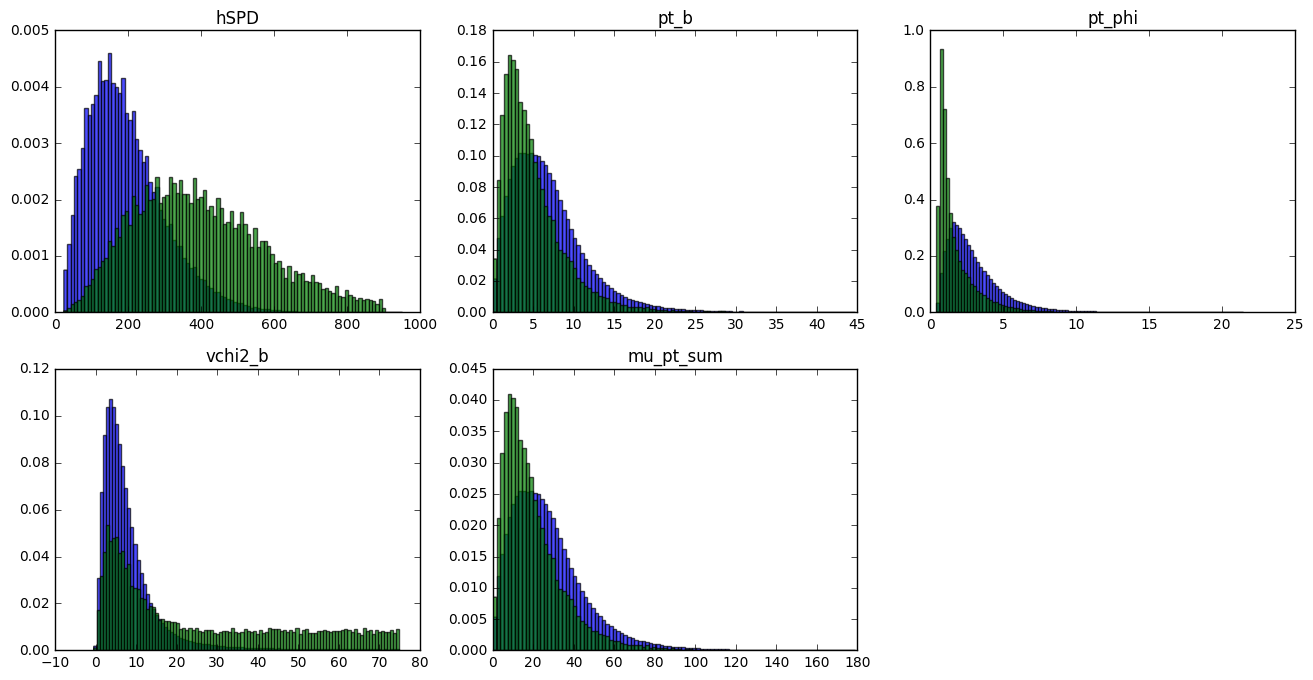

In [7]:
draw_distributions(original, target, original_weights)

### train part of original distribution

KS over  hSPD  =  0.519431840796
KS over  pt_b  =  0.218438696516
KS over  pt_phi  =  0.398840507463
KS over  vchi2_b  =  0.405768805964
KS over  mu_pt_sum  =  0.218438696516


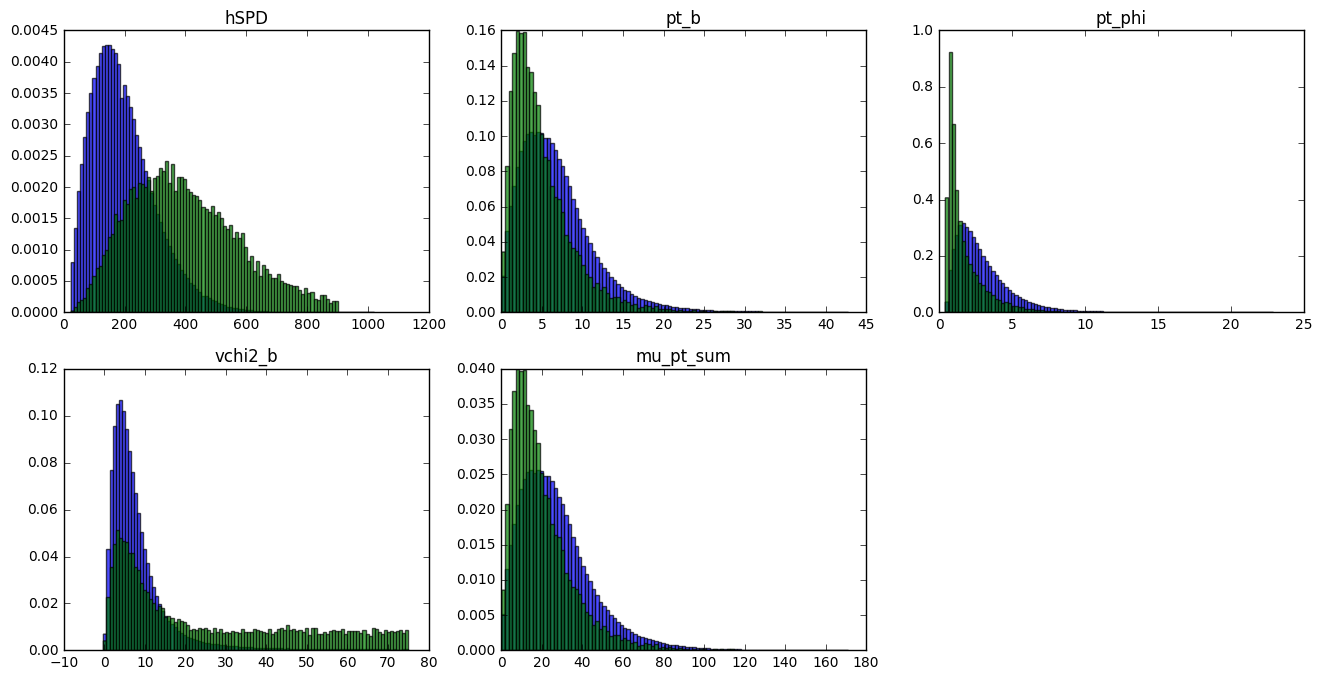

In [8]:
draw_distributions(original_train, target_train, original_weights_train)

### test part for target distribution

KS over  hSPD  =  0.523229411304
KS over  pt_b  =  0.211294713299
KS over  pt_phi  =  0.412539145309
KS over  vchi2_b  =  0.402396012312
KS over  mu_pt_sum  =  0.211294713299


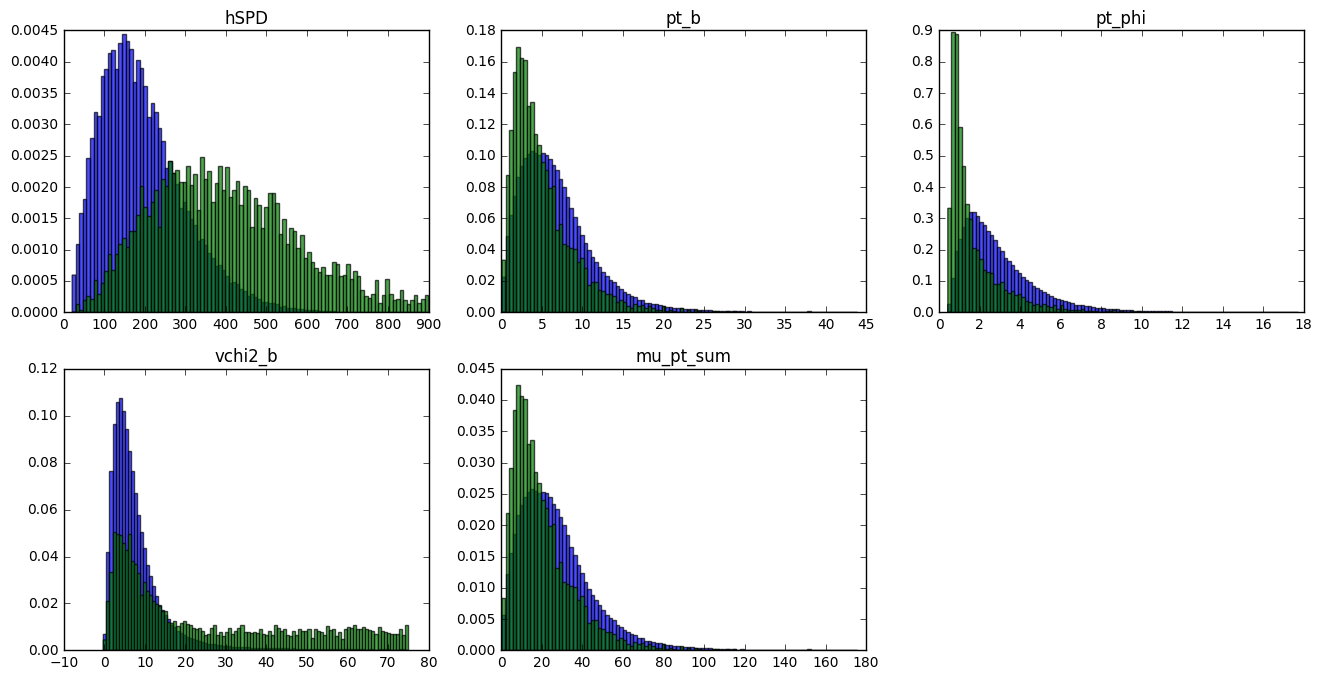

In [9]:
draw_distributions(original_test, target_test, original_weights_test)

# Bins-based reweighting in n dimensions
Typical way to reweight distributions is based on bins.

KS over  hSPD  =  0.298121082557
KS over  pt_b  =  0.088587201134
KS over  pt_phi  =  0.164165100333
KS over  vchi2_b  =  0.257666954018
KS over  mu_pt_sum  =  0.088587201134


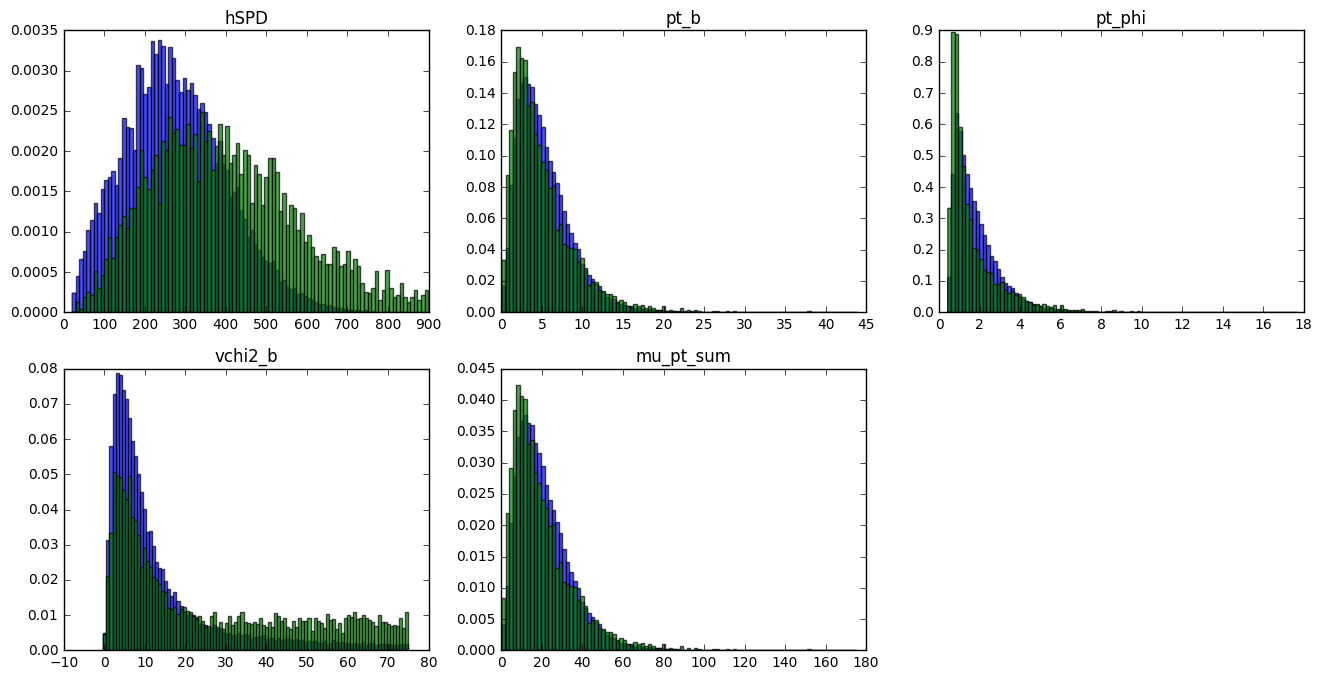

In [10]:
bins_reweighter = reweight.BinsReweighter(n_bins=20, n_neighs=1.)
bins_reweighter.fit(original_train, target_train)

bins_weights_test = bins_reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, bins_weights_test)

# Gradient Boosted Reweighter

This algorithm is inspired by gradient boosting and is able to fight curse of dimensionality.
It uses decision trees and special loss functiion (**ReweightLossFunction**).

**GBReweighter** supports negative weights (to reweight MC to splotted real data).

KS over  hSPD  =  0.0424554384202
KS over  pt_b  =  0.0317914419368
KS over  pt_phi  =  0.0448699596381
KS over  vchi2_b  =  0.0356959588377
KS over  mu_pt_sum  =  0.0317914419368


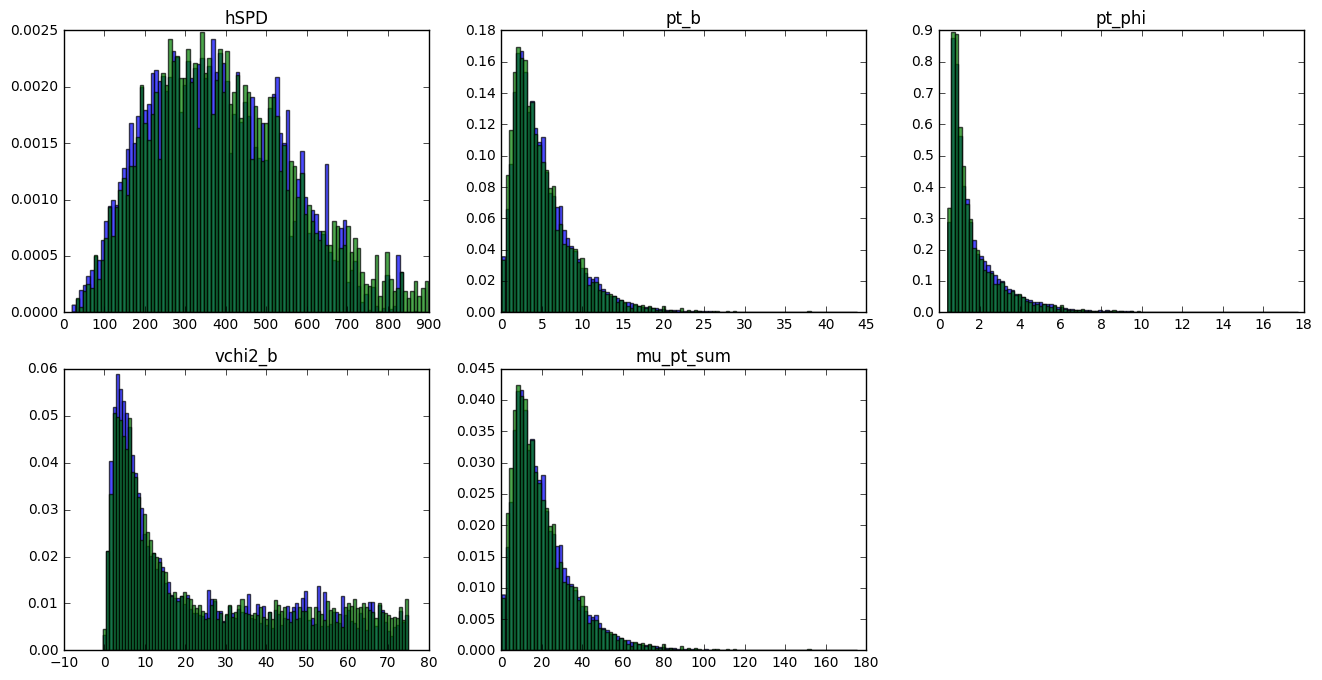

In [11]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                   gb_args={'subsample': 0.4})
reweighter.fit(original_train, target_train)

gb_weights_test = reweighter.predict_weights(original_test)
# validate reweighting rule on the test part comparing 1d projections
draw_distributions(original_test, target_test, gb_weights_test)

## Comparing some simple expressions:
the most interesting is checking some other variables in multidimensional distributions (those are expressed via original variables).

In [12]:
def check_ks_of_expression(expression):
    col_original = original_test.eval(expression, engine='python')
    col_target = target_test.eval(expression, engine='python')
    w_target = numpy.ones(len(col_target), dtype='float')
    print 'No reweight   KS:', ks_2samp_weighted(col_original, col_target, 
                                                 weights1=original_weights_test, weights2=w_target)        
    print 'Bins reweight KS:', ks_2samp_weighted(col_original, col_target, 
                                                 weights1=bins_weights_test, weights2=w_target)
    print 'GB Reweight   KS:', ks_2samp_weighted(col_original, col_target,
                                                 weights1=gb_weights_test, weights2=w_target)

In [13]:
check_ks_of_expression('hSPD')

No reweight   KS: 0.523229411304
Bins reweight KS: 0.298121082557
GB Reweight   KS: 0.0424554384202


In [14]:
check_ks_of_expression('hSPD * pt_phi')

No reweight   KS: 0.0887010345087
Bins reweight KS: 0.123830996775
GB Reweight   KS: 0.0205524572929


In [15]:
check_ks_of_expression('hSPD * pt_phi * vchi2_b')

No reweight   KS: 0.370296237643
Bins reweight KS: 0.275401663473
GB Reweight   KS: 0.0345997749607


In [16]:
check_ks_of_expression('pt_b * pt_phi / hSPD ')

No reweight   KS: 0.479243024436
Bins reweight KS: 0.28621836343
GB Reweight   KS: 0.0568699107029


In [17]:
check_ks_of_expression('hSPD * pt_b * vchi2_b / pt_phi')

No reweight   KS: 0.498986249208
Bins reweight KS: 0.302375251581
GB Reweight   KS: 0.0463411113497


# GB-discrimination
let's check how well the classifier is able to distinguish these distributions. ROC AUC is taken as measure of quality.

For this puprose we split data into train and test, then train a classifier do distinguish these distributions.
If ROC AUC = 0.5 on test, distibutions are equal, if ROC AUC = 1.0, they are ideally separable.

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

data = numpy.concatenate([original_test, target_test])
labels = numpy.array([0] * len(original_test) + [1] * len(target_test))

weights = {}
weights['original'] = original_weights_test
weights['bins'] = bins_weights_test
weights['gb_weights'] = gb_weights_test


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target_test), [1] * len(target_test)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=50).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)

original 0.887797916863
bins 0.794142585399
gb_weights 0.540714109353


# Folding reweighter

With `FoldingReweighter` one can simpler do cross-validation and at the end obtain unbiased weights for the whole original samples

In [19]:
from hep_ml.reweight import FoldingReweighter

KFold prediction using folds column
KS over  hSPD  =  0.0488412903978
KS over  pt_b  =  0.0320990886314
KS over  pt_phi  =  0.0316445887941
KS over  vchi2_b  =  0.033661103536
KS over  mu_pt_sum  =  0.0320990886314


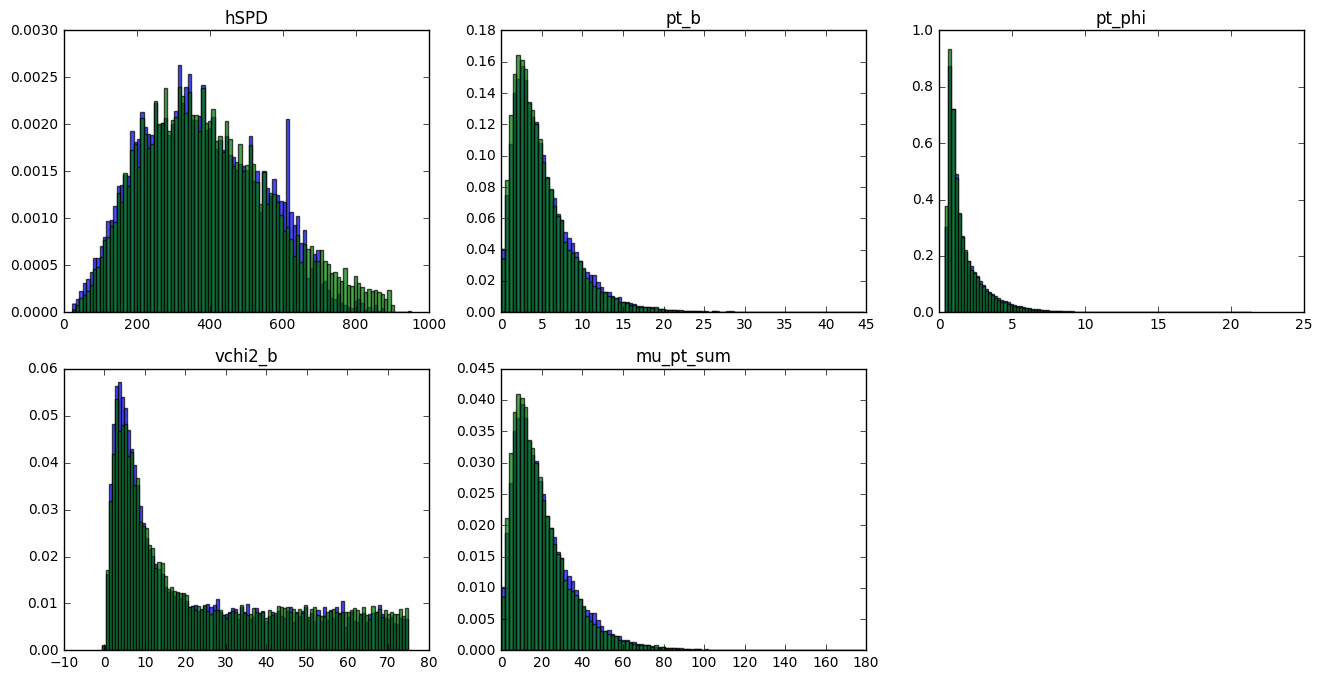

In [20]:
# define base reweighter
reweighter_base = reweight.GBReweighter(n_estimators=50, 
                                        learning_rate=0.1, max_depth=3, min_samples_leaf=1000, 
                                        gb_args={'subsample': 0.4})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; rewighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

draw_distributions(original, target, folding_weights)

### GB discrimination for reweighting rule

In [21]:
data = numpy.concatenate([original, target])
labels = numpy.array([0] * len(original) + [1] * len(target))

weights = {}
weights['original'] = original_weights
weights['2-folding'] = folding_weights


for name, new_weights in weights.items():
    W = numpy.concatenate([new_weights / new_weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)
    
    print name, roc_auc_score(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)

original 0.887911647126
2-folding 0.552895860725
